In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import statsmodels.stats.api as sms

In [2]:
from core.criteria import *
from core.visualization import *

In [3]:
from statsmodels.api import OLS
from statsmodels.api import add_constant

from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from pmdarima import auto_arima
from scipy.stats import shapiro

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [5]:
plt.rcParams['figure.figsize'] = (12, 8)

# Загрузка и просмотр данных

In [6]:
data_path = 'data/META.csv'

In [7]:
stocks_data = pd.read_csv(data_path, index_col='Date', parse_dates=True)
stocks_data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-01,163.029999,165.880005,161.259995,162.440002,162.440002,26407700
2018-10-02,161.580002,162.279999,158.669998,159.330002,159.330002,36031000
2018-10-03,160.000000,163.660004,159.529999,162.429993,162.429993,23109500
2018-10-04,161.460007,161.460007,157.350006,158.850006,158.850006,25739600
2018-10-05,159.210007,160.899994,156.199997,157.330002,157.330002,25744000
2018-10-08,155.539993,158.339996,154.389999,157.250000,157.250000,24046000
2018-10-09,157.690002,160.589996,157.419998,157.899994,157.899994,18844400
2018-10-10,156.820007,157.690002,151.309998,151.380005,151.380005,30610000
2018-10-11,150.130005,154.809998,149.160004,153.350006,153.350006,35338900


In [8]:
close_values = stocks_data.loc[:, ['Close']]
close_values.head(10)

,Close
Date,
2018-10-01,162.440002
2018-10-02,159.330002
2018-10-03,162.429993
2018-10-04,158.850006
2018-10-05,157.330002
2018-10-08,157.250000
2018-10-09,157.899994
2018-10-10,151.380005
2018-10-11,153.350006


Будем учитывать средненедельные показатели, прогноз также будет осуществляться понедельно, то есть можно сказать, что
интервал прогнозирования и период прогнозирования равны одной неделе

In [9]:
close_values = close_values.resample(rule="w").mean(numeric_only=True)

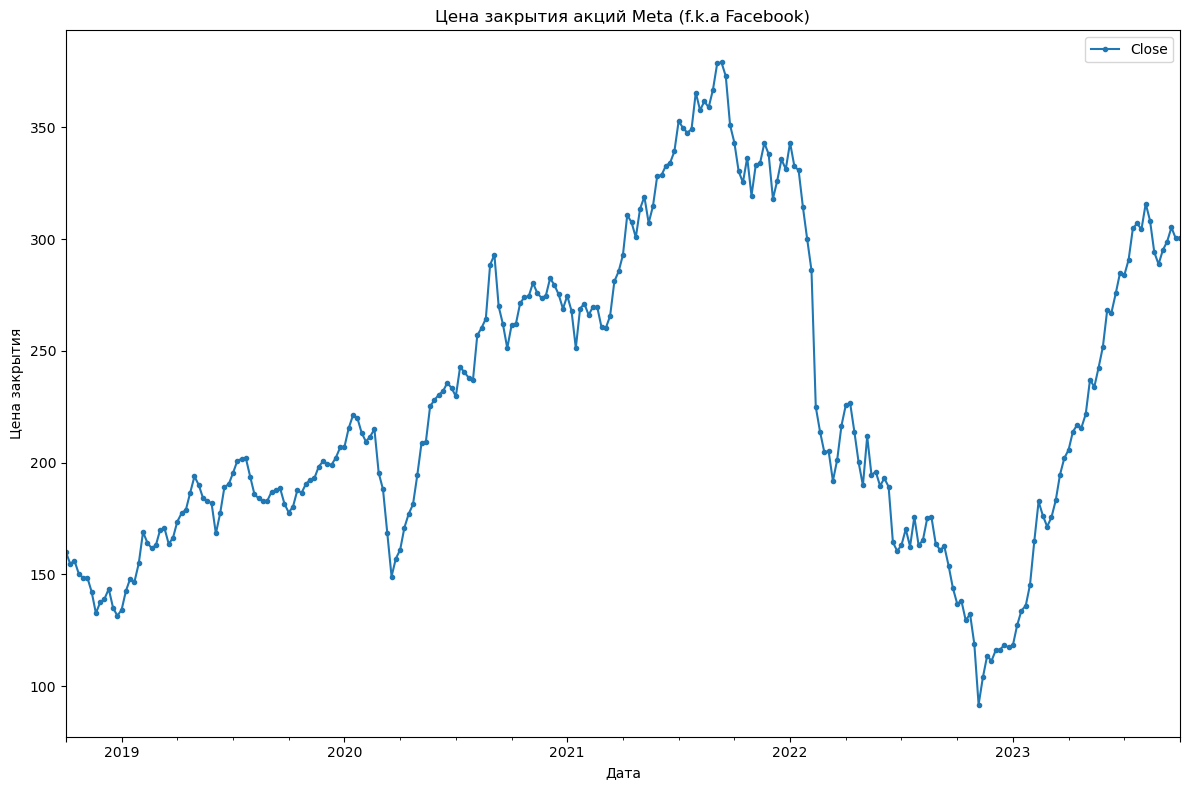

In [10]:
plot_time_series(close_values, 
                title='Цена закрытия акций Meta (f.k.a Facebook)',
                x_label='Дата', y_label='Цена закрытия')

In [11]:
test_model = OLS(close_values, close_values).fit()
test_residuals = test_model.resid

In [12]:
test_close_values = add_constant(close_values, 1)
white_test = het_white(test_residuals, test_close_values)
print("F-Statistic:", white_test[0])
print("p-value:", white_test[1])

F-Statistic: 185.50225835595865
p-value: 5.23234543129513e-41


p-value < 0.05, значит непостоянства дисперсии (в частности ее увеличение) отсутствуют и дополнительных преобразований делать не нужно

# Проверка ряда на наличие и монотонность тренда

In [13]:
foster_stuart_criterion(close_values.to_numpy())

10.292598298743991

In [14]:
len(close_values)

261

Всего у нас 261 наблюдение, следовательно число степеней свободы n = 260, уровень значимости $\alpha$ = 0.05, табличное значение критерия Фостера-Стьюдента - 1.96

Сравнивая с табличным значением принимаем решение об отклонении гипотезы $H_0$ (об отсутствии изменения тренда), следовательно, можно согласиться с гипотезой о наличии тренда 

In [15]:
means_comparison_criterion(close_values.to_numpy())

3.4692050250672906

Всего у нас 261 наблюдение, следовательно число степеней свободы n = 260, уровень значимости $\alpha$ = 0.05, табличное значение критерия Фостера-Стьюдента - 1.96

Сравнивая с табличным значением принимаем решение об отклонении гипотезы $H_0$ (об отсутствии монотонного тренда)

In [16]:
se_test(close_values.to_numpy())

True

Проведя серию тестов, можно констатировать факт (с вероятностью ошибки 0,05) о наличии немонотонного тренда в поведении акций Meta

# Проверка ряда на наличие сезонной компоненты средствами ACF и PACF

In [17]:
stocks_acf = acf(close_values)
stocks_acf

array([1.        , 0.98618938, 0.968303  , 0.94873548, 0.926696  ,
       0.90287017, 0.8792033 , 0.85634096, 0.83075436, 0.80482186,
       0.77859343, 0.75053764, 0.72066432, 0.69356591, 0.66614777,
       0.63792048, 0.60904572, 0.58051189, 0.55071722, 0.51978969,
       0.48817782, 0.45488806, 0.42083258, 0.38822095, 0.35824909])

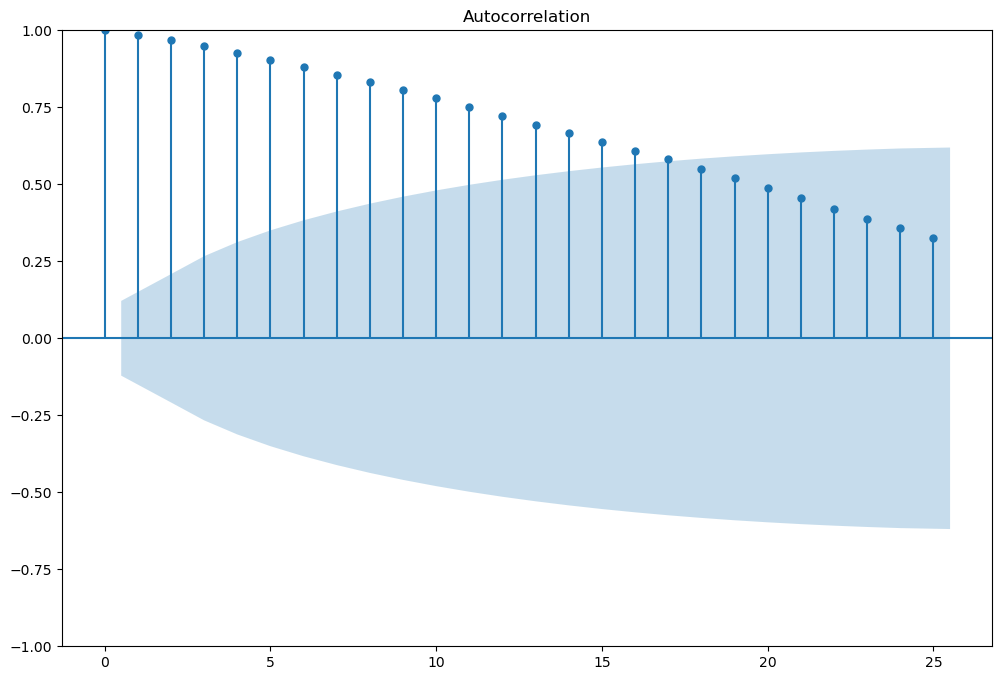

In [18]:
plot_acf(close_values)
plt.show()

In [19]:
stocks_pacf = pacf(close_values)
stocks_pacf

array([ 1.        ,  0.98998242, -0.21494778, -0.05701965, -0.11788567,
       -0.06191028,  0.03239496,  0.03763995, -0.17151818,  0.01447473,
       -0.03809963, -0.0931924 , -0.06811807,  0.17601943, -0.10581649,
       -0.01883717, -0.08057548, -0.0049186 , -0.07988486, -0.00270686,
       -0.11990367, -0.07302639, -0.02943978,  0.08539008,  0.07093156])

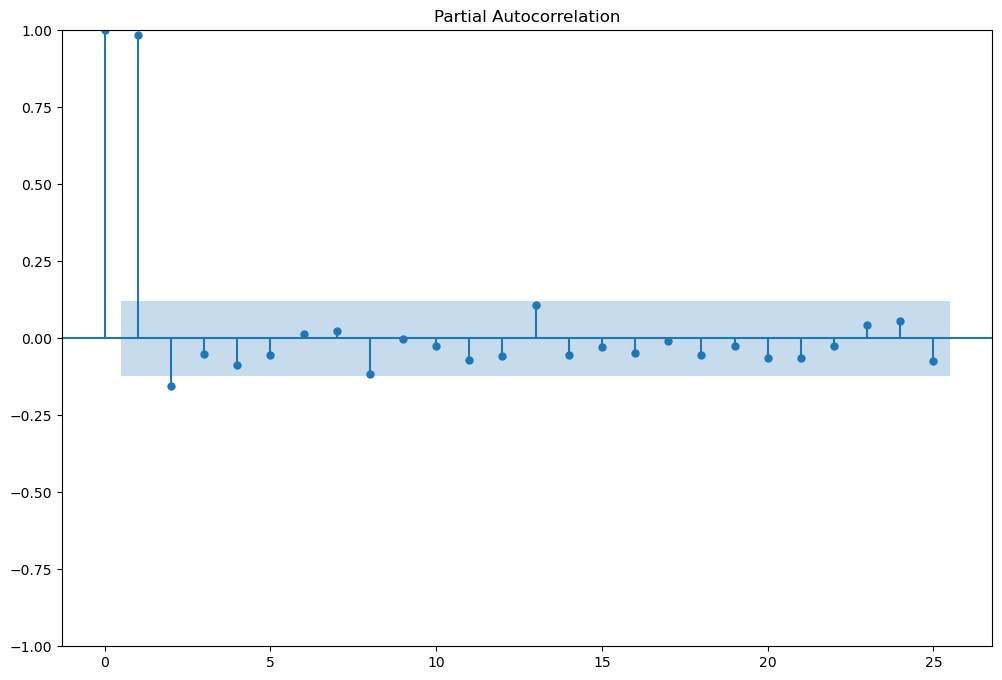

In [20]:
plot_pacf(close_values)
plt.show()

По графикам АКФ и ЧАКФ мы видим что временной ряд скорее всего стационарен и для построения прогноза необходимо брать разность 1-го порядка (поскольку уменьшение АКФ хоть и медленное, но присутствует). В виду присутствия периодичности, параметр d будет равен 1.

АКФ затухает экспоненциально, ЧАКФ имеет резко выделяющиеся значения на лагах 1, 2, корреляции на других лагах в рамках доверительного интервала, следовательно можно предположить, что модель будет иметь 2 параметра авторегрессии

# Проверка на стационарность

In [21]:
box_tests = sms.acorr_ljungbox(close_values, lags=20, boxpierce=True)
lb_pvalue_max = box_tests.lb_pvalue.max()
bp_pvalue_max = box_tests.bp_pvalue.max()

print(f"Наибольшее p-значение для Ljung-Box теста составляет: {lb_pvalue_max}")
print(f"Наибольшее p-значение для Box-Pierce теста составляет: {bp_pvalue_max}")

Наибольшее p-значение для Ljung-Box теста составляет: 8.683399600930677e-58
Наибольшее p-значение для Box-Pierce теста составляет: 3.777208915058242e-57


Для обоих тестов p-значение гораздо меньше чем 0.05, что позволяет отклонить гипотезу отсутствия автокорреляции (незначимость коэффициентов автокорреляции,случайная распределенность данных), распределение Хи-квадрат при степенях свободы равных лагу

In [22]:
adf_result = adfuller(close_values)
adf_statistics = adf_result[0]
adf_p_value = adf_result[1]

print('Ряд нестационарен на', round(adf_p_value * 100, 2), '%')

Ряд нестационарен на 46.51 %


Пусть уровень значимости составляет 5%, сравним значение статистики теста с соответствующим критическим значением

In [23]:
adf_statistics < adf_result[4]['5%']

False

Полученное значение статистики теста больше критического, значит мы принимаем гипотезу $H_0$ о существовании единичного корня, единичный корень в поведении акций Meta ***существует*** 

In [24]:
kpss_result = kpss(close_values, regression='ct')
kpss_p_value = kpss_result[1]
kpss_p_value

0.01

Полученное p-значение меньше 0.05, значит мы отвергаем гипотезу $H_0$ теста KPSS, тренд поведения акций Meta не является стационарным

Избавимся от нестационарности ряда, взяв разность 1-го порядка

In [25]:
first_order_difference = np.diff(stocks_data['Close'])
first_order_difference

array([-3.11    ,  3.099991, -3.579987, ..., -1.869996, -1.220001,
        6.220001])

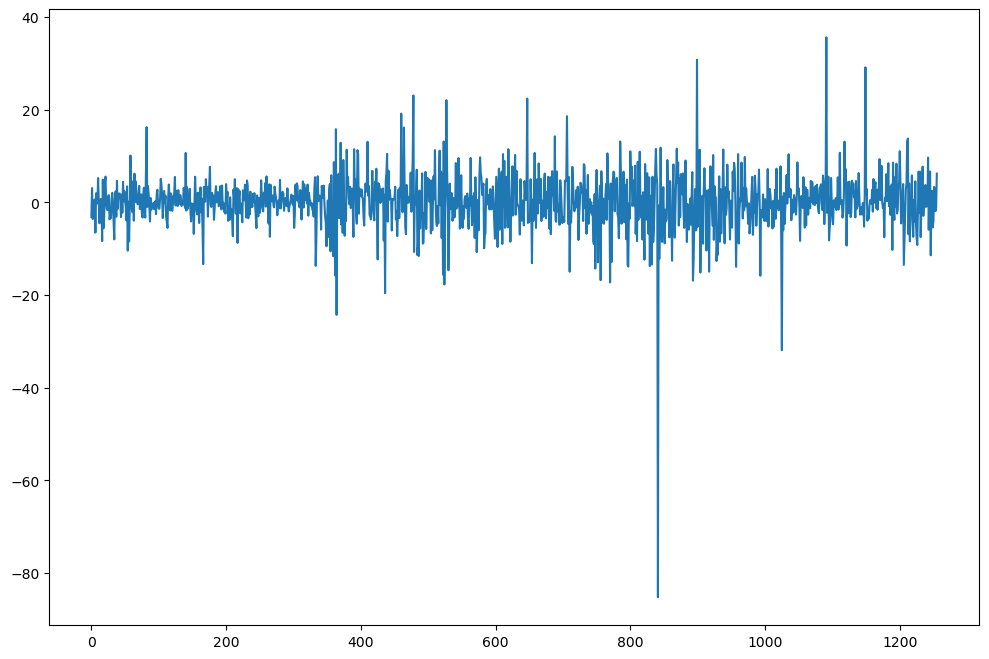

In [26]:
plt.plot(first_order_difference)
plt.show()

Проверим полученную разность на стационарность

In [27]:
box_tests_fo = sms.acorr_ljungbox(first_order_difference, lags=20, boxpierce=True)
lb_pvalue_max_fo = box_tests_fo.lb_pvalue.max()
bp_pvalue_max_fo = box_tests_fo.bp_pvalue.max()

print(f"Наибольшее p-значение для Ljung-Box теста по разности 1-го порядка составляет: {lb_pvalue_max_fo}")
print(f"Наибольшее p-значение для Box-Pierce теста по разности 1-го порядка составляет: {bp_pvalue_max_fo}")

Наибольшее p-значение для Ljung-Box теста по разности 1-го порядка составляет: 0.2312386587724783
Наибольшее p-значение для Box-Pierce теста по разности 1-го порядка составляет: 0.23210564581693205


Для обоих тестов p-значение больше чем 0.05, что позволяет принять гипотезу отсутствия автокорреляции (незначимость коэффициентов автокорреляции,случайная распределенность данных), распределение Хи-квадрат при степенях свободы равных лагу

In [28]:
adf_result_fo = adfuller(first_order_difference)
adf_statistics_fo = adf_result_fo[0]
adf_p_value_fo = adf_result_fo[1]

print('Ряд, полученный путем взятия 1-й разности нестационарен на', round(adf_p_value_fo * 100, 2), '%')

Ряд, полученный путем взятия 1-й разности нестационарен на 0.0 %


Пусть уровень значимости составляет 5%, сравним значение статистики теста с соответствующим критическим значением

In [29]:
adf_statistics_fo < adf_result_fo[4]['5%']

True

Полученное значение статистики теста меньше критического, значит мы отвергаем гипотезу $H_0$ о существовании единичного корня, единичный корень в поведении акций Meta ***отсутствует*** 

In [30]:
kpss_result_fo = kpss(first_order_difference, regression='ct')
kpss_p_value_fo = kpss_result_fo[1]
kpss_p_value_fo

0.05028110247575213

Полученное p-значение больше 0.05, значит мы принимаем гипотезу $H_0$ теста KPSS, тренд поведения 1-й разности акций Meta является стационарным

# Построение предсказывающей модели ARIMA

Автоматизируем подбор оптимальной модели ARIMA по критерию [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), а именно будем считать оптимальной моделью ту, у которой этот критерий наименьший. 

Для автоматизации будем использовать функционал пакета [pmdarima](https://alkaline-ml.com/pmdarima/index.html)

In [31]:
model = auto_arima(close_values, seasonal=False, trace=True, 
                   max_p=10, max_q=10, 
                   stepwise=False,
                   suppress_warnings=True)
model.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1918.236, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1911.285, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1913.000, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1911.820, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1911.773, Time=0.62 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1913.420, Time=0.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1910.650, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1910.878, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1912.124, Time=0.59 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1912.360, Time=0.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1913.673, Time=0.94 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1912.301, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1912.247, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1909.925, Time=1.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1910.602, Time=1.26 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -947.911
Date:                Sat, 25 Nov 2023   AIC                           1909.821
Time:                        18:17:44   BIC                           1934.746
Sample:                    10-07-2018   HQIC                          1919.842
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4044      0.675      0.599      0.549      -0.919       1.728
ar.L1          0.9366      0.124      7.527      0.000       0.693       1.180
ar.L2         -0.9401      0.127     -7.387      0.000      -1.190      -0.691
ar.L3          0.2349      0.069      3.413      0.001       0.100       0.370
ma.L1         -0.7673      0.118     -6.506      0.000      -0.998      -0.536
ma.L2          0.8353      0.107      7.806      0.000       0.626       1.045
sigma2        85.8545      5.695     15.076      0.000      74.693      97.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               278.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.79   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Полученная наилучшая модель близка к поставленной на основе АКФ и ЧАКФ ряда изначально гипотезе о ее виде

Проанализируем остатки выбранной лучшей модели

In [32]:
residuals = model.resid()[1:]

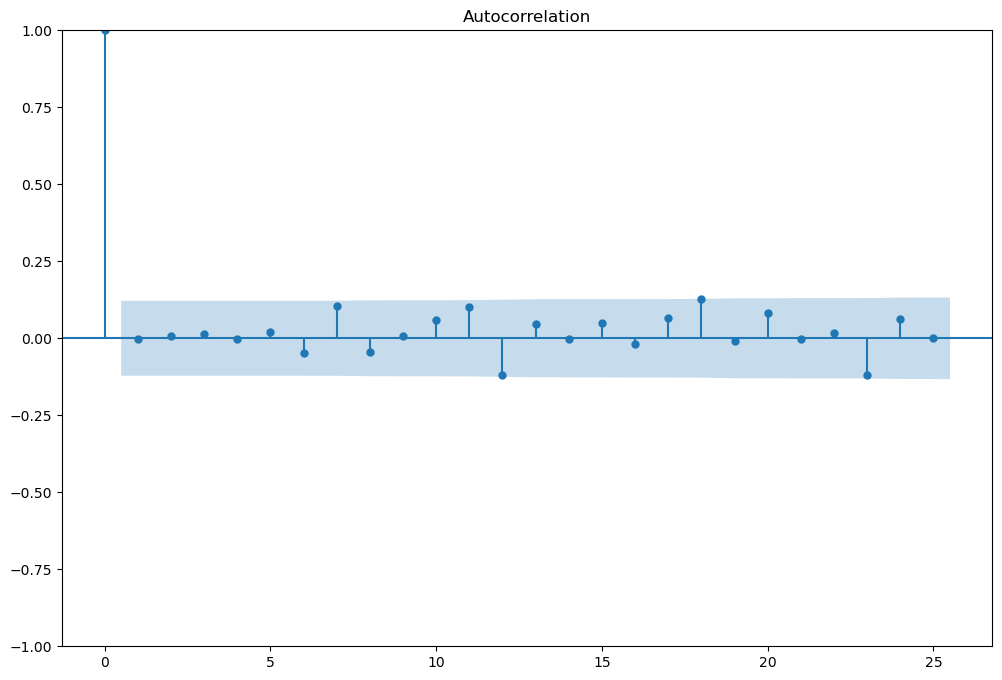

In [33]:
plot_acf(residuals)
plt.show()

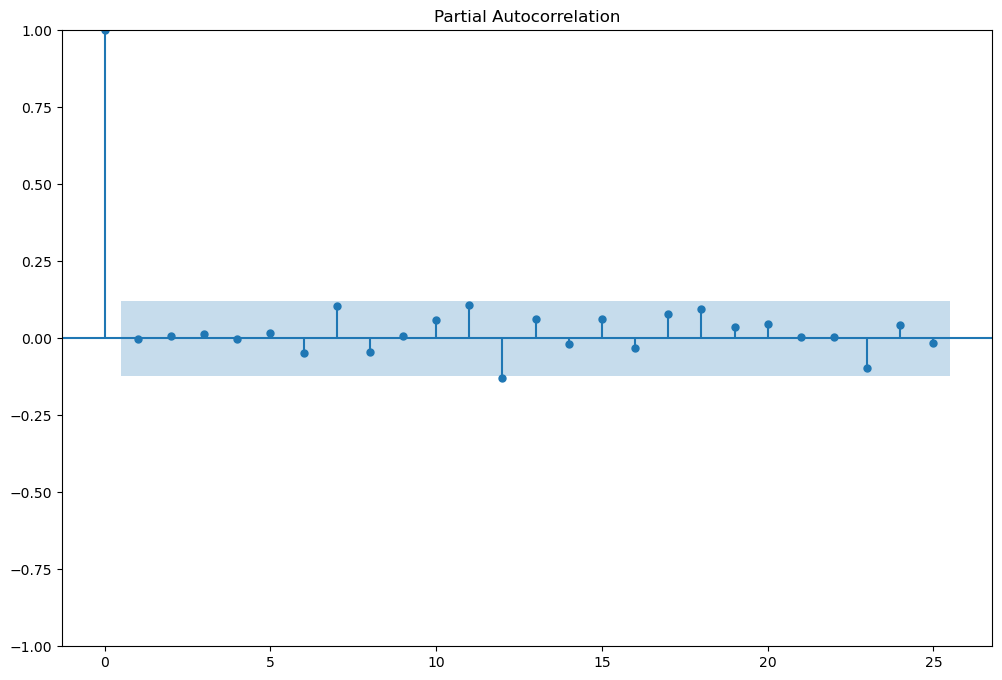

In [34]:
plot_pacf(residuals)
plt.show()

Графики АКФ и ЧАКФ показывают малозначимые остатки, все они лежат в пределах доверительного интервала, что говорит об относительной адекватности выбранной модели

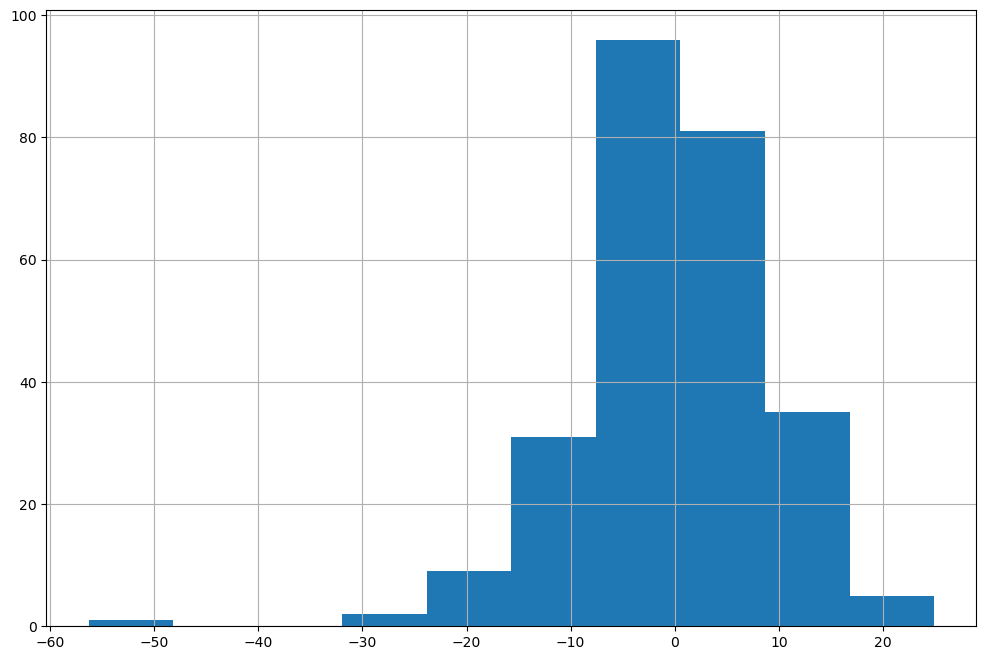

In [35]:
residuals.hist()
plt.show()

In [36]:
shapiro(residuals).pvalue

1.636103377222753e-07

Распределение остатков не является нормальным, что показывает значение критерия Шапиро-Уилка, которое меньше чем 0.05, что говорит против адекватности выбранной модели

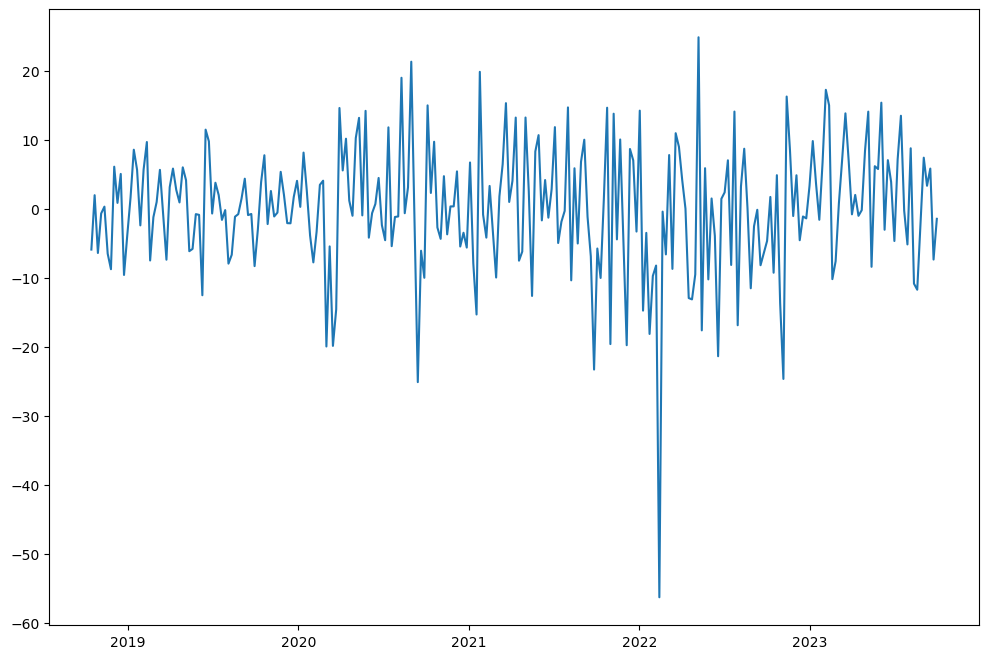

In [37]:
plt.plot(residuals)
plt.show()

График остатков модели визуально напоминает белый шум, что говорит об относительной адекватности модели

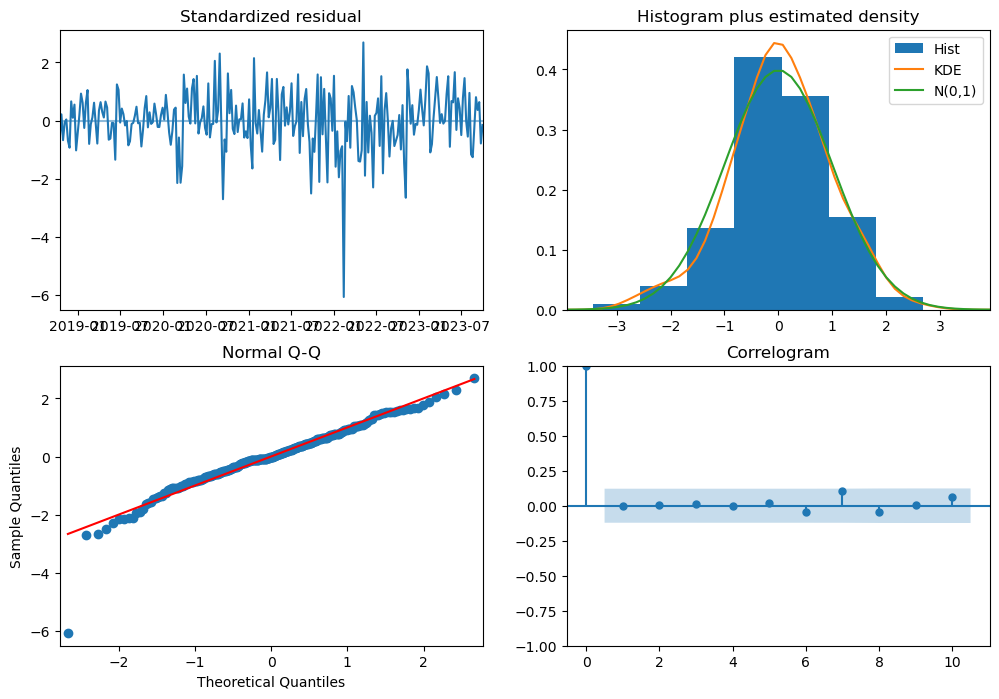

In [38]:
model.plot_diagnostics()
plt.show()

Сводный набор графиков показывает относительную адекватности модели, однако среди остатков имеются выбросы, поэтому об абсолютной адекватности модели говорить рано

# Построение прогноза модели

Спрогнозируем поведение акций Meta на 111 шагов, то есть в данном случае - на 111 недель вперед

In [39]:
prediction = model.predict(n_periods=111).to_frame()
prediction.rename(columns={0: 'Close'}, inplace=True)
prediction.tail(10)

,Close
2025-09-14,352.467166
2025-09-21,352.993331
2025-09-28,353.519496
2025-10-05,354.045662
2025-10-12,354.571827
2025-10-19,355.097992
2025-10-26,355.624157
2025-11-02,356.150322
2025-11-09,356.676488
2025-11-16,357.202653


Определим последниюю дату из "реальных" данных

In [40]:
last_known_date = close_values.tail(1).iloc[0].name
last_known_date

Timestamp('2023-10-01 00:00:00', freq='W-SUN')

Объединим имеющиеся данные и прогноз

In [41]:
close_values_with_prediction = pd.concat([close_values, prediction])
close_values_with_prediction.tail(10)

,Close
2025-09-14,352.467166
2025-09-21,352.993331
2025-09-28,353.519496
2025-10-05,354.045662
2025-10-12,354.571827
2025-10-19,355.097992
2025-10-26,355.624157
2025-11-02,356.150322
2025-11-09,356.676488
2025-11-16,357.202653


Постром график реальных значений и спрогнозированных

In [42]:
actual_close_values = close_values_with_prediction[:last_known_date]
forecasted_close_values = close_values_with_prediction[last_known_date:]

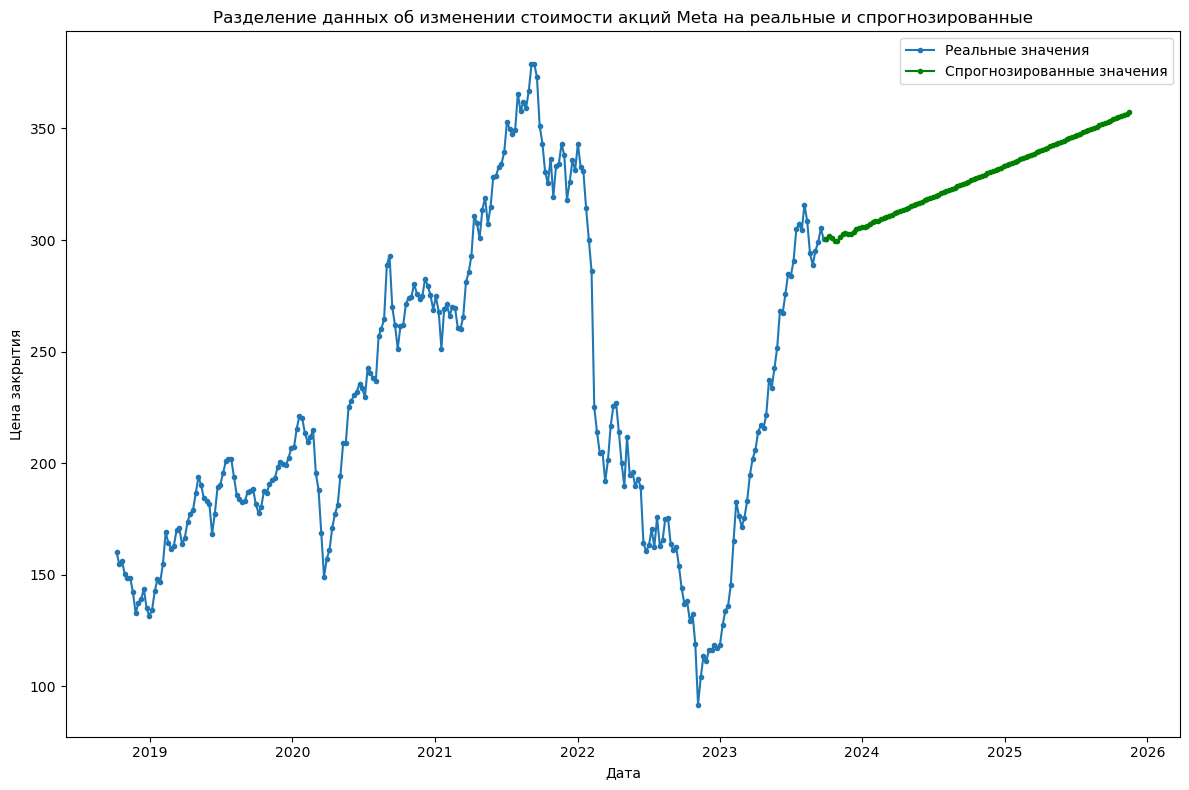

In [43]:
plot_prediction(actual_close_values, forecasted_close_values,
                title='Разделение данных об изменении стоимости акций Meta на реальные и спрогнозированные',
                x_label='Дата',
                y_label='Цена закрытия')

Как видим, модель угадывает общие тренд движения акций, однако ее прогноз - практически сплошная прямая, что говорит о ее слабой адекватности

# Проверка модели на тестовой подвыборке

Разобьем имеющийся ряд на 2 подвыборки - тренировочную (80%) и тестовую (20%)

In [44]:
train_size = 0.8
test_start_index = math.floor(len(close_values) * train_size)
test_start_index

208

In [45]:
close_values_train = close_values[:test_start_index]
close_values_test = close_values[test_start_index:]

assert len(close_values_train) + len(close_values_test) == len(close_values)
print('Тренировочная и тестовая выборки были выделены успешно')

Тренировочная и тестовая выборки были выделены успешно


Сделаем копию имеющейся модели и натренируем ее на тренировочной подвыборке

In [46]:
restoration_model = copy.deepcopy(model)
restoration_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  261
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -947.911
Date:                Sat, 25 Nov 2023   AIC                           1909.821
Time:                        18:17:53   BIC                           1934.746
Sample:                    10-07-2018   HQIC                          1919.842
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4044      0.675      0.599      0.549      -0.919       1.728
ar.L1          0.9366      0.124      7.527      0.000       0.693       1.180
ar.L2         -0.9401      0.127     -7.387      0.000      -1.190      -0.691
ar.L3          0.2349      0.069      3.413      0.001       0.100       0.370
ma.L1         -0.7673      0.118     -6.506      0.000      -0.998      -0.536
ma.L2          0.8353      0.107      7.806      0.000       0.626       1.045
sigma2        85.8545      5.695     15.076      0.000      74.693      97.016
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               278.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.79   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
restoration_model = restoration_model.fit(close_values_train)
restoration_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  208
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -757.277
Date:                Sat, 25 Nov 2023   AIC                           1528.554
Time:                        18:17:55   BIC                           1551.883
Sample:                    10-07-2018   HQIC                          1537.988
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0795      0.790     -0.101      0.920      -1.628       1.469
ar.L1          0.9260      0.104      8.896      0.000       0.722       1.130
ar.L2         -0.9435      0.105     -8.964      0.000      -1.150      -0.737
ar.L3          0.2236      0.078      2.861      0.004       0.070       0.377
ma.L1         -0.7884      0.082     -9.612      0.000      -0.949      -0.628
ma.L2          0.8803      0.078     11.322      0.000       0.728       1.033
sigma2        87.9224      6.451     13.630      0.000      75.279     100.566
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               272.87
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.29   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Построим прогноз, совпадающий по размеру с тестовой подвыборкой

In [48]:
close_values_test_prediction = restoration_model.predict(n_periods=len(close_values_test)).to_frame()
close_values_test_prediction.rename(columns={0: 'Close'}, inplace=True)
close_values_test_prediction.head(10)

,Close
2022-10-02,141.200136
2022-10-09,141.206169
2022-10-16,141.438654
2022-10-23,140.966811
2022-10-30,140.232370
2022-11-06,139.969935
2022-11-13,140.234847
2022-11-20,140.484024
2022-11-27,140.326619
2022-12-04,139.925485


Отобразим реальные и спрогнозированные значения для тестовой выборки на графике

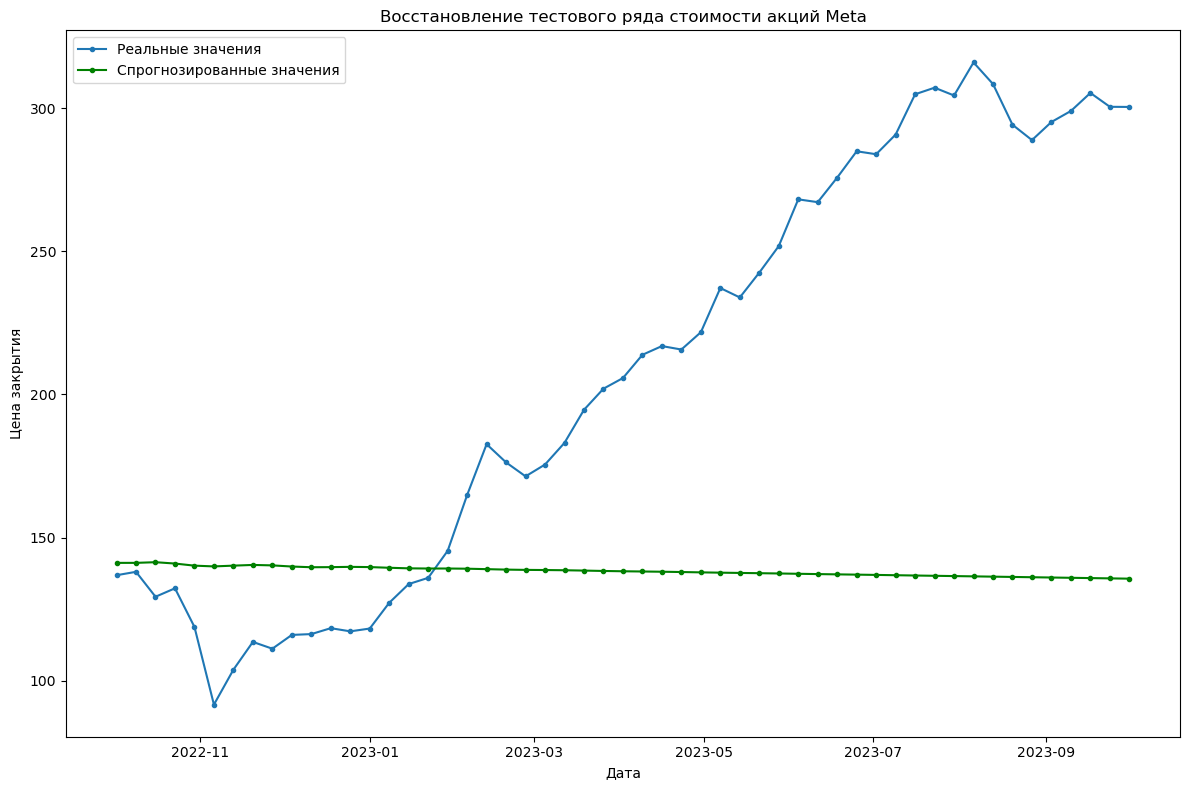

In [49]:
plot_prediction(close_values_test, close_values_test_prediction,
                title='Восстановление тестового ряда стоимости акций Meta',
                x_label='Дата',
                y_label='Цена закрытия')

Как видно, модель снова примерно угадала тренд движения акций, но показала практически прямую линию в качестве прогноза, что говорит о ее слабой адекватности и применимости

Полученная модель ARIMA показывает себя не лучшим образом. Это может быть связано с непредсказуемостью поведений акций Meta (в частности выброс в конце 2022 года), а также с нестационарностью ряда, что является большей причиной неадекватности модели

В данном случае стоит рассмотреть решения, основанные на других математических моделях, либо на основе нейронной сети со слоями [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)